## Part B

In [1]:
import pandas as pd
import numpy as np
from gurobipy import *
from scipy.spatial import distance
pd.options.display.max_rows = 500
import matplotlib.pyplot as plt

### data inport 

In [2]:
DP_data =  pd.read_excel('data.xlsx', sheet_name='DPs')
FC_data =  pd.read_excel('data.xlsx', sheet_name='FCs')

In [3]:
dis_dic = {}
for i in range(len(FC_data)):
    fc_cor = (FC_data[FC_data.index == i].x.values[0], FC_data[FC_data.index == i].y.values[0])
    for j in range(len(DP_data)):
        dp_cor = (DP_data[DP_data.index == j].x.values[0], DP_data[DP_data.index == j].y.values[0])
        dis_dic[(i,j)] = distance.euclidean(fc_cor, dp_cor)

### gurobi model

In [4]:
myModel = Model( "fl_problem" )
var_dic_x = {}
var_dic_y = {}

#decision varaible 
for i in range(len(FC_data)):
    for k in [1,2,3]:
        var_dic_x[(i,k)] = myModel.addVar(vtype = GRB.BINARY , \
                                                       name = "x%s"%(str(i) + '_' + str(k)))
for i in range(len(FC_data)):
    for j in range(len(DP_data)):
        for k in [1,2,3]:
            var_dic_y[(i,j,k)] = myModel.addVar(vtype = GRB.BINARY , \
                                                  name = "y%s"%(str(i) + '_' + str(j) + '_' + str(k)))
myModel.update()  

Academic license - for non-commercial use only


In [5]:
#objective function 
objExpr = LinExpr()
for i in range(len(FC_data)):
    for j in range(len(DP_data)):
        objExpr +=  6* dis_dic[(i,j)] * var_dic_y[(i,j,1)]

for i in range(len(FC_data)):
    for j in range(len(DP_data)):
        objExpr +=  5* dis_dic[(i,j)] * var_dic_y[(i,j,2)]

for i in range(len(FC_data)):
    for j in range(len(DP_data)):
        objExpr +=  9* dis_dic[(i,j)] * var_dic_y[(i,j,3)]

myModel.setObjective(objExpr , GRB.MINIMIZE)
myModel.update()  

In [6]:
#constraint function
for i in range(len(FC_data)):
    for j in range(len(DP_data)):
        for k in [1,2,3]:
            Constr_1 = LinExpr()
            for k_ in [m for m in range(1, k +1)]:
                Constr_1 += var_dic_x[(i,k)] 
            myModel.addConstr( lhs = var_dic_y[(i,j,k)] , sense = GRB.LESS_EQUAL, \
                   rhs = Constr_1 , name = "Const_1_" + (str(i) + '_' + str(j) + '_' + str(k)) )

for j in range(len(DP_data)):
    for k in [1,2,3]: 
        Constr_2 = LinExpr()
        for i in range(len(FC_data)):
            Constr_2 += var_dic_y[(i,j,k)]
        myModel.addConstr( lhs = Constr_2 , sense = GRB.EQUAL , rhs = 1 , \
                       name = "Const_2_" + str(i)+ '_' + str(k) )

for k in [1,2,3]:
    Constr_3 = LinExpr()
    for i in range(len(FC_data)):
        Constr_3 += var_dic_x[(i,k)] 
    myModel.addConstr( lhs = Constr_3 , sense = GRB.EQUAL , rhs = k , \
                       name = "Const_3_" + str(i)+ '_' + str(k) )
        
for i in range(len(FC_data)):
    for k in [1,2]:
        Constr_open = LinExpr()
        for k_ in [1,2,3]:
            if k_ > k: 
                Constr_open += var_dic_x[(i,k_)]
        myModel.addConstr( lhs = var_dic_x[(i,k)] , sense = GRB.LESS_EQUAL , rhs =  Constr_open , \
                               name = "Const_open_" + str(i)+ '_' + str(k) ) 

    
    
myModel.update()
# write the model in a file to make sure it is constructed correctly
myModel.write( filename = "fl.lp" )

# optimize the model
myModel.optimize()

# check the status of the model
curStatus = myModel.status
if curStatus in (GRB.Status.INF_OR_UNBD, GRB.Status.INFEASIBLE, \
              GRB.Status.UNBOUNDED):
    print( "Could not find the optimal solution" )
    exit(1)

# print optimal objective and optimal solution
print( "\nOptimal Objective: " + str( myModel.ObjVal ) )


Optimize a model with 683 rows, 630 columns and 1880 nonzeros
Variable types: 0 continuous, 630 integer (630 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [2e+01, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]
Presolve removed 220 rows and 200 columns
Presolve time: 0.04s
Presolved: 463 rows, 430 columns, 1270 nonzeros
Variable types: 0 continuous, 430 integer (430 binary)
Found heuristic solution: objective 15783.984968

Root relaxation: objective 1.276015e+04, 223 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    12760.151023 12760.1510  0.00%     -    0s

Explored 0 nodes (223 simplex iterations) in 0.16 seconds
Thread count was 4 (of 4 available processors)

Solution count 2: 12760.2 15784 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.27601510

### result output and plot 

In [7]:
myVars = myModel.getVars()
df = pd.DataFrame({'name': [i.varName for i in myVars], 'value':[i.x for i in myVars]})
df['label'] = df.name.apply(lambda x:x[0])
df['k'] = df.name.apply(lambda x:x[-1])
df_x = df[df.label=='x'].copy().sort_values('k')
df_y = df[df.label=='y'].copy().sort_values('k')
df_y['i'] = df_y.name.apply(lambda x: x[1:].split('_')[0])
df_y['j'] = df_y.name.apply(lambda x: x[1:].split('_')[1])
df_y['cost'] =df_y.apply(lambda x: dis_dic[(int(x.i), int(x.j))],axis=1)

In [8]:
FC_data['FC index'] = FC_data.index
FC_data[['FC index','x','y']]

,FC index,x,y
0,0,60,15
1,1,26,36
2,2,73,34
3,3,57,54
4,4,18,19
5,5,11,1
6,6,60,77
7,7,68,44
8,8,97,65
9,9,4,79


In [9]:
open_dc = set([])
for k in df_x.k.unique():
    print ('Stage %s, ALL open FC: %s, NEW optimal open FC:%s'%(k, str(set([i.split('_')[0][1] \
                                                for i in df_x[(df_x.k == k)&(df_x.value == 1)].name])),
                                      str(set([i.split('_')[0][1] \
                                                for i in df_x[(df_x.k == k)&(df_x.value == 1)].name])\
                                          - open_dc )))
    open_dc = set([i.split('_')[0][1] for i in df_x[(df_x.k == k)&(df_x.value == 1)].name])


Stage 1, ALL open FC: {'6'}, NEW optimal open FC:{'6'}
Stage 2, ALL open FC: {'6', '0'}, NEW optimal open FC:{'0'}
Stage 3, ALL open FC: {'6', '9', '0'}, NEW optimal open FC:{'9'}


#### 1 FC case plot

In [10]:
# this array includes the coordinates of fulfillment centers
# there are 10 fulfillment center locations
# for each fulfillment center, we keep x and y coordinates
nofcs = 10
fcs = [ 0 for j in range ( nofcs ) ]
fcs[0] = [60 , 15]
fcs[1] = [26 , 36]
fcs[2] = [73 , 34]
fcs[3] = [57 , 54]
fcs[4] = [18 , 19]
fcs[5] = [11 , 1]
fcs[6] = [60 , 77]
fcs[7] = [68 , 44]
fcs[8] = [97 , 65]
fcs[9] = [4 , 79]

# this array includes the coordinates of demand points
# there are 10 demand points
# for each demand point, we keep x and y coordinates
# for this example, there are 20 demand points
nodps = 20
dps = [ 0 for j in range ( nodps ) ]
dps[0] = [25 , 75]
dps[1] = [49 , 7]
dps[2] = [17 , 8]
dps[3] = [12 , 84]
dps[4] = [3 , 83]
dps[5] = [57 , 5]
dps[6] = [46 , 39]
dps[7] = [83 , 89]
dps[8] = [78 , 96]
dps[9] = [27 , 44]
dps[10] = [64 , 16]
dps[11] = [52 , 86]
dps[12] = [57 , 72]
dps[13] = [33 , 55]
dps[14] = [66 , 47]
dps[15] = [25 , 28]
dps[16] = [9 , 97]
dps[17] = [85 , 87]
dps[18] = [98 , 3]
dps[19] = [19 , 97]

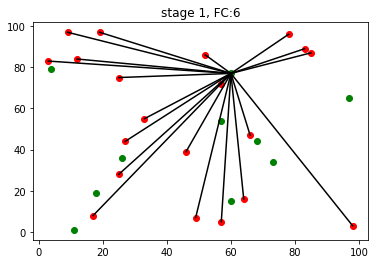

In [11]:
# this array includes which fulfillment center each demand point is connected to
# for this example, dem pnt 0 is connected to full cen 1, but dem pnt 8 is connected to full cen 6

#period 1
assgns = [ 0 for j in range ( nodps ) ]
for assign in  [( int(i.split('_')[0][1]), int(i.split('_')[1])) \
         for i in df_y[(df_y.value==1)&(df_y.k=='1')].name.values]:
    assgns[assign[1]] = assign[0]

for fc in range( nofcs ):
    plt.plot( fcs[ fc ][ 0 ]  , fcs[ fc ][ 1 ] , 'ro' , color = "green" , lw = 9 )
    
for dp in range( nodps ):
    plt.plot( dps[ dp ][ 0 ]  , dps[ dp ][ 1 ] , 'ro' , color = "red" , lw = 9 )

for dp in range( nodps ):
    dpx = dps[ dp ][ 0 ]
    dpy = dps[ dp ][ 1 ]
    fcx = fcs[ assgns[ dp ] ][ 0 ]
    fcy = fcs[ assgns[ dp ] ][ 1 ]
    plt.plot( [ dpx , fcx ], [ dpy , fcy ]  , color = "black"  )
    plt.title('stage 1, FC:6')

plt.show()


#### 2 FC case plot

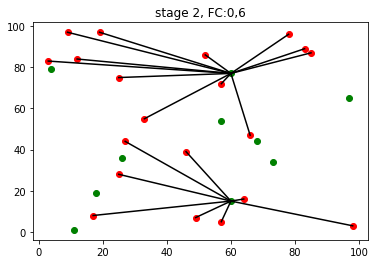

In [12]:
# this array includes which fulfillment center each demand point is connected to
# for this example, dem pnt 0 is connected to full cen 1, but dem pnt 8 is connected to full cen 6

#period 2
assgns = [ 0 for j in range ( nodps ) ]
for assign in  [( int(i.split('_')[0][1]), int(i.split('_')[1])) \
         for i in df_y[(df_y.value==1)&(df_y.k=='2')].name.values]:
    assgns[assign[1]] = assign[0]

for fc in range( nofcs ):
    plt.plot( fcs[ fc ][ 0 ]  , fcs[ fc ][ 1 ] , 'ro' , color = "green" , lw = 9 )
    
for dp in range( nodps ):
    plt.plot( dps[ dp ][ 0 ]  , dps[ dp ][ 1 ] , 'ro' , color = "red" , lw = 9 )

for dp in range( nodps ):
    dpx = dps[ dp ][ 0 ]
    dpy = dps[ dp ][ 1 ]
    fcx = fcs[ assgns[ dp ] ][ 0 ]
    fcy = fcs[ assgns[ dp ] ][ 1 ]
    plt.plot( [ dpx , fcx ], [ dpy , fcy ]  , color = "black"  )
    plt.title('stage 2, FC:0,6')

plt.show()

#### 3 FC case plot

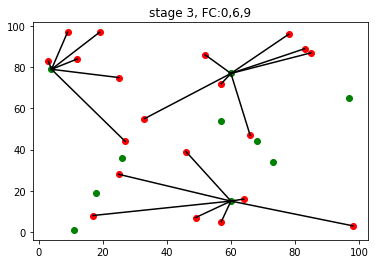

In [13]:
# this array includes which fulfillment center each demand point is connected to
# for this example, dem pnt 0 is connected to full cen 1, but dem pnt 8 is connected to full cen 6

#period 3
assgns = [ 0 for j in range ( nodps ) ]
for assign in  [( int(i.split('_')[0][1]), int(i.split('_')[1])) \
         for i in df_y[(df_y.value==1)&(df_y.k=='3')].name.values]:
    assgns[assign[1]] = assign[0]

for fc in range( nofcs ):
    plt.plot( fcs[ fc ][ 0 ]  , fcs[ fc ][ 1 ] , 'ro' , color = "green" , lw = 9 )
    
for dp in range( nodps ):
    plt.plot( dps[ dp ][ 0 ]  , dps[ dp ][ 1 ] , 'ro' , color = "red" , lw = 9 )

for dp in range( nodps ):
    dpx = dps[ dp ][ 0 ]
    dpy = dps[ dp ][ 1 ]
    fcx = fcs[ assgns[ dp ] ][ 0 ]
    fcy = fcs[ assgns[ dp ] ][ 1 ]
    plt.plot( [ dpx , fcx ], [ dpy , fcy ]  , color = "black"  )
    plt.title('stage 3, FC:0,6,9')

plt.show()